<a href="https://colab.research.google.com/github/ethanchuicy/insti_resistance_model/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import dataset
import pandas as pd
col_names = []
df = pd.read_csv('/integrase_dataset', sep='\t')
print(df)

      RefID  IsolateID     IsolateName Species      Type      PtID  \
0      1497      82027            263K    HIV1       Lab       NaN   
1      1497      82021      92Q+147G+1    HIV1       Lab       NaN   
2      1497      82023            121Y    HIV1       Lab       NaN   
3      1497      82014             51Y    HIV1       Lab       NaN   
4      1497      82022      92Q+147G+2    HIV1       Lab       NaN   
...     ...        ...             ...     ...       ...       ...   
1098   3136     642656  HPTN083_D3_W33    HIV1  Clinical  321364.0   
1099   3136     642659  HPTN083_D4_W37    HIV1  Clinical  321365.0   
1100   3197     664048            ISO3    HIV1       Lab       NaN   
1101   3197     664046            ISO1    HIV1       Lab       NaN   
1102   3197     664047            ISO2    HIV1       Lab       NaN   

          Method  BIC BICFoldMatch   CAB  ... P279  P280 P281 P282 P283 P284  \
0     PhenoSense  NaN          NaN   NaN  ...    -     -    -    -    -    -   

In [2]:
df = df.drop(columns = ['RefID', 'IsolateID', 'IsolateName', 'Species', 'Type', 'PtID', 'Method'])
print(df.head())

   BIC BICFoldMatch  CAB CABFoldMatch  DTG DTGFoldMatch  EVG EVGFoldMatch  \
0  NaN          NaN  NaN          NaN  NaN          NaN  4.9            =   
1  NaN          NaN  NaN          NaN  NaN          NaN  160            =   
2  NaN          NaN  NaN          NaN  NaN          NaN   11            =   
3  NaN          NaN  NaN          NaN  NaN          NaN  4.0            =   
4  NaN          NaN  NaN          NaN  NaN          NaN  182            =   

   RAL RALFoldMatch  ... P279 P280 P281 P282 P283  P284  P285 P286 P287 P288  
0  1.4            =  ...    -    -    -    -    -     -     -    -    -    -  
1  6.4            =  ...    -    -    -    -    -     -     -    -    -    -  
2  6.9            =  ...    -    -    -    -    -     -     -    -    -    -  
3  NaN          NaN  ...    -    -    -    -    -     -     -    -    -    -  
4  5.7            =  ...    -    -    -    -    -     -     -    -    -    -  

[5 rows x 306 columns]


In [3]:
df1= df.drop(columns = ['BICFoldMatch', 'CABFoldMatch', 'DTGFoldMatch', 'EVGFoldMatch', 'RALFoldMatch', 'CompleteMutationListAvailable', 'Author'])
print(df1.head())

   BIC  CAB  DTG  EVG  RAL       INIMajorDRMs  INIMinorDRMs  \
0  NaN  NaN  NaN  4.9  1.4              R263K         D232N   
1  NaN  NaN  NaN  160  6.4  H51Y, E92Q, S147G         D232N   
2  NaN  NaN  NaN   11  6.9              F121Y         D232N   
3  NaN  NaN  NaN  4.0  NaN               H51Y         D232N   
4  NaN  NaN  NaN  182  5.7  H51Y, E92Q, S147G  E157Q, D232N   

                           NonDRMs  RefYear  MedlineID  ... P279 P280 P281  \
0  E10D, I72V, S123G, T124A, K127R     2007        NaN  ...    -    -    -   
1  E10D, I72V, S123G, T124A, K127R     2007        NaN  ...    -    -    -   
2  E10D, I72V, S123G, T124A, K127R     2007        NaN  ...    -    -    -   
3  E10D, I72V, S123G, T124A, K127R     2007        NaN  ...    -    -    -   
4  E10D, I72V, S123G, T124A, K127R     2007        NaN  ...    -    -    -   

  P282 P283 P284 P285 P286 P287 P288  
0    -    -    -    -    -    -    -  
1    -    -    -    -    -    -    -  
2    -    -    -    -    -    -    

In [4]:
df2= df1.drop(columns=['INIMajorDRMs', 'INIMinorDRMs', 'NonDRMs', 'RefYear', 'MedlineID'])
print(df2.head())

   BIC  CAB  DTG  EVG  RAL                                              Title  \
0  NaN  NaN  NaN  4.9  1.4  Resistance profile of HIV-1 mutants in vitro s...   
1  NaN  NaN  NaN  160  6.4  Resistance profile of HIV-1 mutants in vitro s...   
2  NaN  NaN  NaN   11  6.9  Resistance profile of HIV-1 mutants in vitro s...   
3  NaN  NaN  NaN  4.0  NaN  Resistance profile of HIV-1 mutants in vitro s...   
4  NaN  NaN  NaN  182  5.7  Resistance profile of HIV-1 mutants in vitro s...   

  P1 P2 P3 P4  ... P279 P280 P281 P282 P283 P284 P285 P286 P287 P288  
0  -  -  -  -  ...    -    -    -    -    -    -    -    -    -    -  
1  -  -  -  -  ...    -    -    -    -    -    -    -    -    -    -  
2  -  -  -  -  ...    -    -    -    -    -    -    -    -    -    -  
3  -  -  -  -  ...    -    -    -    -    -    -    -    -    -    -  
4  -  -  -  -  ...    -    -    -    -    -    -    -    -    -    -  

[5 rows x 294 columns]


In [5]:
df3= df2.drop(columns=['Title'])
print(df3.head())

   BIC  CAB  DTG  EVG  RAL P1 P2 P3 P4 P5  ... P279 P280 P281 P282 P283 P284  \
0  NaN  NaN  NaN  4.9  1.4  -  -  -  -  -  ...    -    -    -    -    -    -   
1  NaN  NaN  NaN  160  6.4  -  -  -  -  -  ...    -    -    -    -    -    -   
2  NaN  NaN  NaN   11  6.9  -  -  -  -  -  ...    -    -    -    -    -    -   
3  NaN  NaN  NaN  4.0  NaN  -  -  -  -  -  ...    -    -    -    -    -    -   
4  NaN  NaN  NaN  182  5.7  -  -  -  -  -  ...    -    -    -    -    -    -   

  P285 P286 P287 P288  
0    -    -    -    -  
1    -    -    -    -  
2    -    -    -    -  
3    -    -    -    -  
4    -    -    -    -  

[5 rows x 293 columns]


In [6]:
all_pos_columns = [f'P{i}' for i in range(1, 289)]
df3[all_pos_columns] = df3[all_pos_columns].replace('-', 0)
print(df3.head())

   BIC  CAB  DTG  EVG  RAL  P1 P2 P3 P4 P5  ... P279 P280 P281  P282 P283  \
0  NaN  NaN  NaN  4.9  1.4   0  0  0  0  0  ...    0    0    0     0    0   
1  NaN  NaN  NaN  160  6.4   0  0  0  0  0  ...    0    0    0     0    0   
2  NaN  NaN  NaN   11  6.9   0  0  0  0  0  ...    0    0    0     0    0   
3  NaN  NaN  NaN  4.0  NaN   0  0  0  0  0  ...    0    0    0     0    0   
4  NaN  NaN  NaN  182  5.7   0  0  0  0  0  ...    0    0    0     0    0   

  P284 P285 P286 P287  P288  
0    0    0    0    0     0  
1    0    0    0    0     0  
2    0    0    0    0     0  
3    0    0    0    0     0  
4    0    0    0    0     0  

[5 rows x 293 columns]


<ipython-input-6-bfebfcaeb476>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df3[all_pos_columns] = df3[all_pos_columns].replace('-', 0)


In [7]:
#Apply one-hot encoding
encoded_df = pd.get_dummies(df3[all_pos_columns])


df4 = df3.drop(all_pos_columns, axis=1)
df5 = pd.concat([df4, encoded_df], axis=1)


print(df5)

      BIC   CAB   DTG  EVG  RAL  P1  P9  P15  P19  P29  ...  P286_DN  P286_N  \
0     NaN   NaN   NaN  4.9  1.4   0   0    0    0    0  ...    False   False   
1     NaN   NaN   NaN  160  6.4   0   0    0    0    0  ...    False   False   
2     NaN   NaN   NaN   11  6.9   0   0    0    0    0  ...    False   False   
3     NaN   NaN   NaN  4.0  NaN   0   0    0    0    0  ...    False   False   
4     NaN   NaN   NaN  182  5.7   0   0    0    0    0  ...    False   False   
...   ...   ...   ...  ...  ...  ..  ..  ...  ...  ...  ...      ...     ...   
1098  2.9   2.3   2.3  4.1  1.4   0   0    0    0    0  ...    False   False   
1099  2.8  13.0   2.1  107   43   0   0    0    0    0  ...    False   False   
1100  NaN   NaN  28.0  NaN  NaN   0   0    0    0    0  ...    False   False   
1101  NaN   NaN   1.1  NaN  NaN   0   0    0    0    0  ...    False   False   
1102  NaN   NaN   7.2  NaN  NaN   0   0    0    0    0  ...    False   False   

      P287_0  P287_.  P287_EK  P288_0  

In [8]:
df5['EVG'] = pd.to_numeric(df5['EVG'], errors='coerce')


In [9]:
df5['RAL'] = pd.to_numeric(df5['RAL'], errors='coerce')

In [10]:
df_filled = df5.fillna(-999)
bic_list = df_filled['BIC'].to_list()
cab_list = df_filled['CAB'].to_list()
dtg_list = df_filled['DTG'].to_list()
evg_list = df_filled['EVG'].to_list()
ral_list = df_filled['RAL'].to_list()

resistance= []

for i in range(0, 1103):
  if bic_list[i]>3.5:
    resistance.append(1)
  elif cab_list[i]>3.5:
    resistance.append(1)
  elif dtg_list[i]>3.5:
    resistance.append(1)
  elif evg_list[i]>3.5:
    resistance.append(1)
  elif ral_list[i]>3.5:
    resistance.append(1)
  else:
    resistance.append(0)

print(resistance)
print(len(resistance))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [11]:
df5['Resistance']= resistance
print(df5.head())

   BIC  CAB  DTG    EVG  RAL  P1  P9  P15  P19  P29  ...  P286_N  P287_0  \
0  NaN  NaN  NaN    4.9  1.4   0   0    0    0    0  ...   False    True   
1  NaN  NaN  NaN  160.0  6.4   0   0    0    0    0  ...   False    True   
2  NaN  NaN  NaN   11.0  6.9   0   0    0    0    0  ...   False    True   
3  NaN  NaN  NaN    4.0  NaN   0   0    0    0    0  ...   False    True   
4  NaN  NaN  NaN  182.0  5.7   0   0    0    0    0  ...   False    True   

   P287_.  P287_EK  P288_0  P288_.  P288_DN  P288_N  P288_X  Resistance  
0   False    False    True   False    False   False   False           1  
1   False    False    True   False    False   False   False           1  
2   False    False    True   False    False   False   False           1  
3   False    False    True   False    False   False   False           1  
4   False    False    True   False    False   False   False           1  

[5 rows x 1139 columns]


In [13]:
columns_to_exclude = ['BIC', 'CAB', 'DTG', 'EVG', 'RAL', 'Resistance']
df_selected = df5.drop(columns=columns_to_exclude)
X = df_selected
y= df5['Resistance']

In [14]:
#Divide dataset into k-fold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [15]:
#log regression model
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression

my_lambda = 10
c = 1/my_lambda
model = LogisticRegression(solver='liblinear', penalty='l1', C=c)
score = cross_val_score(model, X, y, cv=cv, n_jobs=-1)

print(score)
print(mean(score))
print(std(score))

[0.85585586 0.88288288 0.85585586 0.81818182 0.84545455 0.9
 0.80909091 0.89090909 0.88181818 0.93636364]
0.8676412776412776
0.0365909264484429


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [17]:
final_model = model.fit(X_train, y_train)
prediction = final_model.predict(X_test)
#metrics
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, prediction)


In [18]:
#Gert coefficients
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
print(final_model.coef_)

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.26733928  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.11035869  0.          0.          0.          0.          0.
   0.     

In [19]:
coef_list = final_model.coef_.tolist()
index_list = []

for i in range(len(coef_list[0])):
  if coef_list[0][i] != 0:
    index_list.append(i)


print(index_list)

col_names = X.columns.values.tolist()
print(col_names[466])

print(coef_list[0][466])

for i in index_list:
  print(col_names[i])
  print(coef_list[0][i])





[70, 84, 300, 362, 384, 398, 418, 452, 466, 493, 504, 567, 575, 598, 625, 720, 770, 861, 1003, 1038]
P118_R
0.579380622578292
P11_0
0.26733928449006394
P17_0
0.11035868752458854
P72_V
1.2352570788784945
P92_0
-0.946471322001362
P97_A
1.6100578578647633
P101_0
0.27398188448529176
P111_0
0.40388236424969315
P113_V
0.007110842130442244
P118_R
0.579380622578292
P124_0
0.335003908771353
P125_0
0.08627819579404133
P140_S
0.02449531332235302
P143_0
-0.3907299921682348
P148_0
-2.408233889469541
P155_H
1.8440341645324758
P181_0
0.1391977846667904
P201_0
0.3952331572794625
P220_0
0.2581981174901467
P256_0
0.553755712990441
P265_0
0.12609484788389053


In [20]:
#classification report
from sklearn.metrics import classification_report
target_names = ['Not Resistant', 'Resistant']
print(classification_report(y_test, prediction, target_names=target_names))

               precision    recall  f1-score   support

Not Resistant       0.83      0.94      0.89       127
    Resistant       0.91      0.74      0.82        94

     accuracy                           0.86       221
    macro avg       0.87      0.84      0.85       221
 weighted avg       0.87      0.86      0.86       221



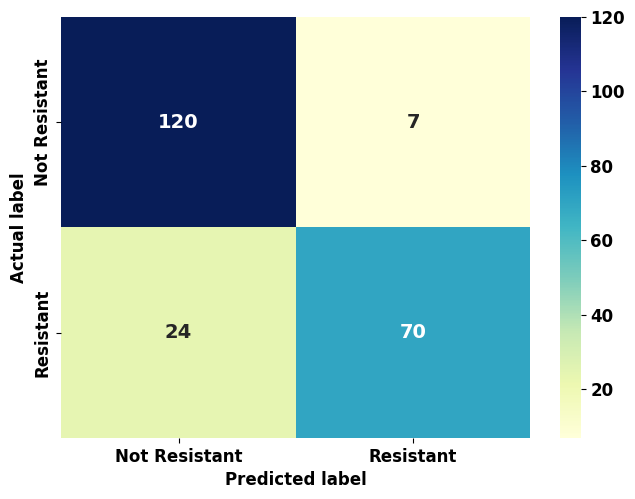

In [22]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=['Not Resistant', 'Resistant'] # name  of classes
fig, ax = plt.subplots()
# create confusion matrix
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g', annot_kws={"size": 14, "weight": "bold"})
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel('Actual label', fontsize=12, fontweight="bold")
plt.xlabel('Predicted label', fontsize=12, fontweight="bold")
ax.set_xticklabels(class_names, fontsize=12, fontweight="bold" )
ax.set_yticklabels(class_names, fontsize=12, fontweight="bold" )
ax.xaxis.set_label_position('bottom')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12, labelcolor='black')  # Tick size and color
for label in cbar.ax.get_yticklabels():
    label.set_fontweight("bold")



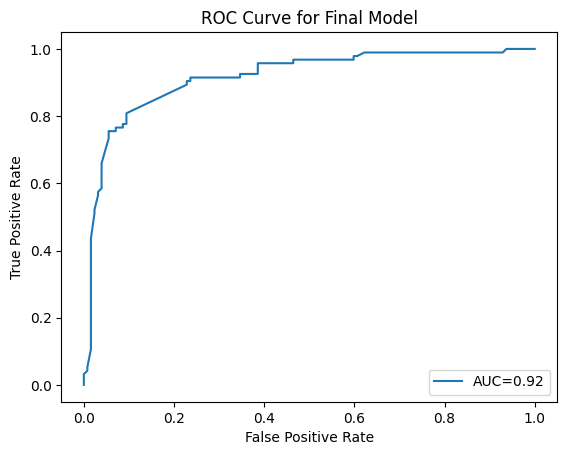

In [23]:
#roc curve
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.legend(loc=4)
plt.title('ROC Curve for Final Model')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()